<center>
<img src="./figures/pylbm_logo.png" style="width: 90%;" />
</center>
&nbsp;
<center>
<span style="text-decoration:underline">Loïc Gouarin</span>, Benjamin Graille
</center>
<center style="font-size=normal">
Laboratoire de mathématiques d'Orsay
</center>
&nbsp;
<center>
3 avril 2018 - GTN CMAP
</center>

## Project goal

Have an all in one lattice Boltzmann toolbox 

- for the mathematicians to test new schemes, new parameters, ...
- for the physicists to perform realistic simulation in their field
- for the computer scientists to test new implementation and optimization

## Project overview

- written in Python
- research code and (we hope) production code
- schemes are defined by the user (classical or vectorial)
- flexible
- optimized code generation
- MPI support



## Define a lattice Boltzmann scheme
 
A lattice Boltzmann scheme is given by

- a set of $q$ velocities adapted to the mesh, $c_0,\ldots,c_{q-1}$,
- an invertible matrix $M$ that transforms the densities into the moments:

$$
m_k = \sum_{j=0}^{q-1} M_{kj} f_j = \sum_{j=0}^{q-1} P_k(c_j) f_j,
 \qquad P_k\in\mathbb{R}[X],
$$

- functions defining the equilibrium $m_k^{eq}$,
- relaxation parameters $s_k$.

The $n$th first moments are necessary the unknowns of the PDEs: these moments are conserved, that is

$$
m_k^{eq} = m_k, \qquad 0\leq k\leq n-1.
$$

The next moments are not conserved and their equilibrium value depends on the conserved moments:

$$
m_k^{eq} = m_k^{eq}(m_0,\ldots,m_{n-1}), \qquad n\leq k\leq q-1.
$$

## Summary of one time step

The starting point is the distribution functions $f(x, t)$ in $x\in \mathcal{L}$ at time $t$.

- #### The computation of the moments $\scriptsize{m(x, t) = M f(x,t)}$

- #### The relaxation phase $\scriptsize{m^*_k(x,t)=m_k(x,t)+s_k(m_k^{eq}(x, t) - m_k(x,t)), \; 0 \leq k\leq q-1}$

- #### The computation of the densities $\scriptsize{f^*(x, t) = M^{-1}m^*(x, t)}$

- #### The transport phase $\scriptsize{f_j(x, t+\Delta t) = f_j^*(x-v_j\Delta t, t), \; 0 \leq j \leq q-1}$

## Example

<center>
<img src="./figures/example_scheme.png" style="width: 90%;" />
</center>

## User must provide

- velocities,
- the domain with its obstacles,
- conserved moments,
- polynomials that describe the change of basis which diagonalizes the relaxation operator,
- equilibria,
- the diagonal of the collapse matrix Ŝ,
- the boundary conditions,
- the code generator (optional).


## Example

We want to solve the advection equation on a torus using a $D_1Q_2$ scheme

$$
\left\{
\begin{array}{l}
\partial_t u(x, t) + c \partial_x u(x, t) = 0 \;, t > 0,\; 0 < x < 1,\; c=1/4, \\
u(t=0,x) = u_0(x), \\
u(t,x=0) = u(t,x=1)
\end{array}
\right.
$$

where $u$ is the unknown. 

The $D_1Q_2$ scheme is given by

- two velocities $\{-\lambda, \lambda\}$ with $\lambda=\Delta x/\Delta t$ and the associated densities $(f_-, f_+)$
- the matrix $M$ and it's inverse

$$
 M = \begin{pmatrix} 1 & 1 \\ -\lambda&\lambda \end{pmatrix}
 \qquad
 M^{-1} = \begin{pmatrix} 1/2&-1/(2\lambda) \\ 1/2&1/(2\lambda) \end{pmatrix}
$$

- the conserved moment $u$ and the non conserved moment $v$, 
 where $u=f_-+f_+$ and $v=-\lambda f_-+ \lambda f_+$.
- the equilibrium value $v^{eq} = v^{eq}(u)$ and the relaxation parameter $s$.

### Initialization 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import pyLBM

X, LA, u = sp.symbols('X,LA,u')

def u0(x):
    return np.exp(-.5*(x%1-.5)**2/0.05**2)

la = 1.
Tf = 4.
c = .25
s = 1.99

/home/loic/miniconda3/envs/pylbm/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Scheme and domain definition

In [2]:
D1Q2 = {
    'box': {'x': [0., 1.], 'label': -1},
    'space_step': 1./128,
    'scheme_velocity': la,
    'schemes':[
        {
            'velocities': [1, 2],
            'conserved_moments': u,
            'polynomials': [1, X],
            'relaxation_parameters': [0., s],
            'equilibrium': [u, c*u],
            'init': {u:(u0,)},
        },
    ],
}

### Simulation and plotting

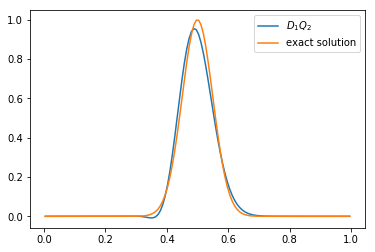

In [3]:
sol = pyLBM.Simulation(D1Q2) # build the simulation
while sol.t < Tf:            # time loop
    sol.one_time_step()      # increment the solution of one time step

x = sol.domain.x

plt.plot(x, sol.m[u], x, u0(x-c*sol.t))
plt.legend(["$D_1Q_2$", "exact solution"])
plt.show()

## Basic blocks of pyLBM

- the velocities and the stencils,
- the geometry,
- the domain,
- the scheme,
- the boundary conditions.

### The velocities

- A velocity is defined by
    + its dimension and an integer
    + its coordinates
- The numbering of the velocities follows the convention for 1D and 2D problems.

In [4]:
from pyLBM.stencil import Velocity

Velocity(dim=1, num=2)

(2: -1)

In [5]:
Velocity(dim=2, num=5)

(5: 1, 1)

In [6]:
Velocity(vx=1, vy=1)

(5: 1, 1)

In [7]:
v = Velocity(vx=1, vy=1)
v.get_symmetric()

(7: -1, -1)

In [8]:
v.get_symmetric(axis=0)

(8: 1, -1)

### The stencils

they define a set of velocities for each scheme involved in the simulation.
<div style="height:20px;"></div>
#### Methods

- single velocities or for each scheme,
- velocities around a direction,
- maximal and minimal velocities in each direction,
- check if a velocity have its symmetric,
- ...

### Stencil for a scheme with nine velocities

In [9]:
import pyLBM

s = pyLBM.Stencil({'dim': 2, 
                   'schemes': [{'velocities': range(9)}]
                  })

print(s)

Stencil informations
	 * spatial dimension: 2
	 * maximal velocity in each direction: [1 1]
	 * minimal velocity in each direction: [-1 -1]
	 * Informations for each elementary stencil:
		stencil 0
		 - number of velocities:  9
		 - velocities: (0: 0, 0), (1: 1, 0), (2: 0, 1), (3: -1, 0), (4: 0, -1), (5: 1, 1), (6: -1, 1), (7: -1, -1), (8: 1, -1), 



In [10]:
print(s.uvx)

[ 0  1  0 -1  0  1 -1 -1  1]


In [11]:
print(s.vx[0])

[ 0  1  0 -1  0  1 -1 -1  1]


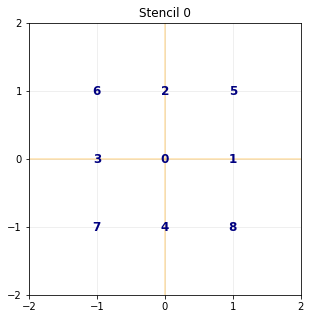

In [12]:
s.visualize()

### Coupled stencils (4 + 4 + 9 velocities)

In [13]:
s = pyLBM.Stencil({'dim': 2, 
                   'schemes': [{'velocities': range(1, 5)},
                               {'velocities': range(1, 5)},
                               {'velocities': range(9)},
                              ]
                  })

print(s)

Stencil informations
	 * spatial dimension: 2
	 * maximal velocity in each direction: [1 1]
	 * minimal velocity in each direction: [-1 -1]
	 * Informations for each elementary stencil:
		stencil 0
		 - number of velocities:  4
		 - velocities: (1: 1, 0), (2: 0, 1), (3: -1, 0), (4: 0, -1), 
		stencil 1
		 - number of velocities:  4
		 - velocities: (1: 1, 0), (2: 0, 1), (3: -1, 0), (4: 0, -1), 
		stencil 2
		 - number of velocities:  9
		 - velocities: (0: 0, 0), (1: 1, 0), (2: 0, 1), (3: -1, 0), (4: 0, -1), (5: 1, 1), (6: -1, 1), (7: -1, -1), (8: 1, -1), 



In [14]:
s.vmax

array([1, 1], dtype=object)

In [15]:
s.uvx

array([ 0,  1,  0, -1,  0,  1, -1, -1,  1])

In [16]:
s.vx[0]

array([ 1,  0, -1,  0])

In [17]:
s.vx[2]

array([ 0,  1,  0, -1,  0,  1, -1, -1,  1])

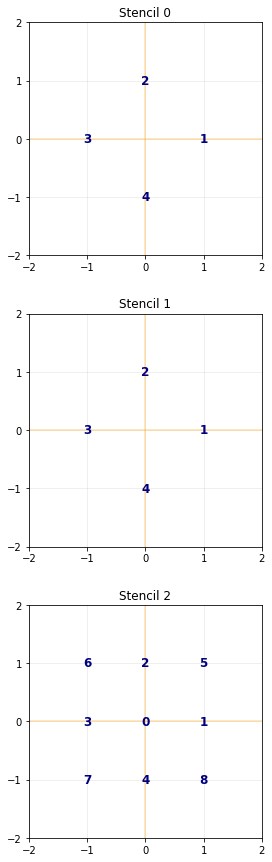

In [18]:
s.visualize()

### The geometry

pyLBM can define 1D, 2D and 3D geometry.

A geometry is given by the dimension of the box and the labels associated.

Only the 2D case can have a union of simple obstacles like 
- a circle,
- a parallelogram,
- a triangle.

### 2D box

In [19]:
g = pyLBM.Geometry({'box': {'x': [0, 1], 'y': [0, 1], 'label':0}, 
                  })
print(g)

Geometry informations
	 spatial dimension: 2
	 bounds of the box: 
[[0. 1.]
 [0. 1.]]



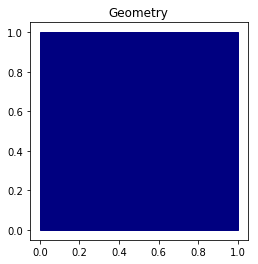

In [20]:
g.visualize()

### 2D box with obstacles

In [21]:
square = pyLBM.Parallelogram((.1, .1), (.8, 0), (0, .8), isfluid=False)
strip = pyLBM.Parallelogram((0, .4), (1, 0), (0, .2), isfluid=True)
circle = pyLBM.Circle((.5, .5), .25, isfluid=True)
inner_square = pyLBM.Parallelogram((.4, .5), (.1, .1), (.1, -.1), isfluid=False)

g = pyLBM.Geometry({'box':{'x': [0, 1], 'y': [0, 1], 'label':0},
                    'elements':[square, strip, circle, inner_square],
                    })

print(g)

Geometry informations
	 spatial dimension: 2
	 bounds of the box: 
[[0. 1.]
 [0. 1.]]
	 List of elements added or deleted in the box
		 Element number 0: Parallelogram([0.1 0.1],[0.8 0. ],[0.  0.8]) (solid)
		 Element number 1: Parallelogram([0.  0.4],[1 0],[0.  0.2]) (fluid)
		 Element number 2: Circle([0.5 0.5],0.25) (fluid)
		 Element number 3: Parallelogram([0.4 0.5],[0.1 0.1],[ 0.1 -0.1]) (solid)



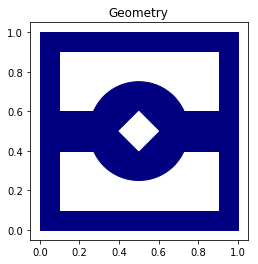

In [22]:
g.visualize()

### The domain

The domain is given by a geometry, one or several schemes and a space step.
<div style="height:20px;"></div>
#### Methods

- type of mesh points: fluid or solid,
- distance computation for each velocity between the mesh points and the border of the obstacles,
- labels of the border for each computed minimal distance.

### A simple fluid 2D domain

In [23]:
s = pyLBM.Domain({'box': {'x': [0, 1], 'y': [0, 1], 'label':0}, 
                                   'space_step': .1,
                                   'schemes': [{'velocities': list(range(9))}]
                                 })
print(s)

Domain informations
	 spatial dimension: 2
	 space step: dx= 1.000e-01



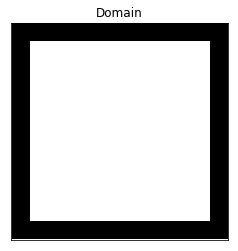

In [24]:
s.visualize()

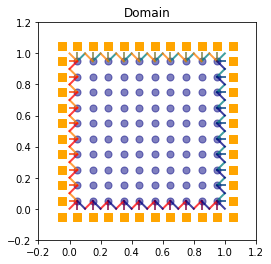

In [25]:
s.visualize(view_distance=True)

### With obstacles

In [26]:
d = pyLBM.Domain({'box': {'x': [0, 1], 'y': [0, 1], 'label':0}, 
                                    'elements': [pyLBM.Circle((.25, .5), .2)],
                                    'space_step': .05,
                                    'schemes': [{'velocities': list(range(9))}]
                  })

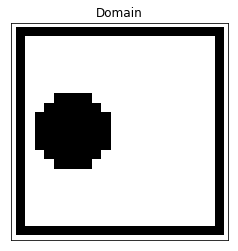

In [27]:
d.visualize()

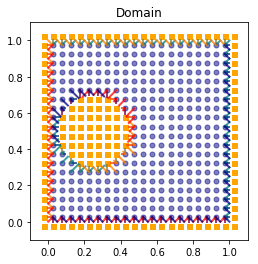

In [28]:
d.visualize(view_distance=True)

### The scheme

A scheme is defined by:

- a set of velocities,
- conserved moments,
- polynomials,
- equilibria,
- relaxation coefficients.

### Boundary conditions

- bounce back and anti bounce back
- Bouzidi
- Neumann
- periodic

### Storage

- same access to the moments and disribution functions arrays
- can access with the name of the conserved moments
- different storage in memory in order to have the best performance for the selected generator
- in charge of the scatter process between the sub domains

### Code generator

- NumPy
- Cython
- loo.py

## Structure of the code


<center>
    <img style="width:70%;" src="./figures/structure.png"/>
</center>

## Next release (soon)

- improve code generation to implement other languages
    - Pythran
    - loopy
- relative velocity
- better packaging


## Next features

- tools for scaling and performance estimations
- Strang operator
- transport strategies
- equivalent equations
- multiresolution